In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, Multiply, Conv2D, Activation, Lambda, Add, Concatenate, BatchNormalization,\
      Input, MaxPooling2D, concatenate, Dropout
from keras.models import Model
from keras import backend as K
import tensorflow as tf 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import time
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, recall_score, confusion_matrix, classification_report, f1_score, precision_recall_curve, precision_score
import numpy as np
import seaborn as sns
import keras
import matplotlib.cm as cm
from keras.utils import load_img,img_to_array,array_to_img
from keras.applications.xception import Xception, preprocess_input, decode_predictions
import cv2
from keras.callbacks import LearningRateScheduler


In [2]:
# Set the path to the dataset
dataset_path = 'E:\L6C6\mv\Rice_Image_Dataset'

# Initialize empty lists for storing the images and labels
images = []
labels = []

# Loop over the subfolders in the dataset
for subfolder in os.listdir(dataset_path):

    subfolder_path = os.path.join(dataset_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue

  # Loop over the images in the subfolder
    for image_filename in os.listdir(subfolder_path):
       # Load the image and store it in the images list
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)

        # Store the label for the image in the labels list
        labels.append(subfolder)

 # Create a pandas DataFrame from the images and labels
df = pd.DataFrame({'image': images, 'label': labels})

In [3]:
X_train, X_remaining, y_train, y_remaining = train_test_split(df['image'], df['label'], test_size=0.3, random_state=42)

test_ratio = 0.5
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=test_ratio, random_state=42)

df_train = pd.DataFrame({'image': X_train, 'label': y_train})
df_val = pd.DataFrame({'image': X_val, 'label': y_val})
df_test = pd.DataFrame({'image': X_test, 'label': y_test})

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_val = encoder.transform(y_val)
y_test = encoder.transform(y_test)

In [4]:
image_size = (50, 50)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

val_generator = datagen.flow_from_dataframe(
    df_val,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 52500 validated image filenames belonging to 5 classes.
Found 11250 validated image filenames belonging to 5 classes.
Found 11250 validated image filenames belonging to 5 classes.


In [5]:
def squeeze_excite_block(input_shape, ratio=16):
    channel_axis = -1
    se_shape = (1, 1, input_shape.shape[channel_axis])
    squeezed = GlobalAveragePooling2D()(input_shape)
    squeezed = Reshape(se_shape)(squeezed)

    x = Dense(input_shape.shape[channel_axis] // ratio, activation='relu')(squeezed)
    x = Dense(input_shape.shape[channel_axis], activation='sigmoid')(x)

    output_shape = Multiply()([input_shape, x])
    return output_shape

In [6]:
def spatial_attention_block(input_shape):
    avg_pool = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(input_shape)
    max_pool = Lambda(lambda x: K.max(x, axis=-1, keepdims=True))(input_shape)

    concat = Concatenate(axis=-1)([avg_pool, max_pool])

    attention = Conv2D(1, (7, 7), padding='same', activation='sigmoid')(concat)

    output_shape = Multiply()([input_shape, attention])
    return output_shape

In [7]:
def res_block(input_shape, filters, strides=1, use_conv_shortcut=False):

    # Main path
    x = Conv2D(filters, (1, 1), strides=strides, padding='same')(input_shape)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters * 4, (1, 1), padding='same')(x)
    x = BatchNormalization()(x)

    # Shortcut path
    shortcut = input_shape
    if use_conv_shortcut or strides != 1 or input_shape.shape[-1] != filters * 4:
        shortcut = Conv2D(filters * 4, (1, 1), strides=strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Combining main path with shortcut
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)
    se_output = spatial_attention_block(x)

    return se_output

In [8]:
def build_resnet(input_shape, num_classes, num_blocks_list, dropout_rate=0.2):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(32, (3, 3), strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)
    
    for i, num_blocks in enumerate(num_blocks_list):
        for j in range(num_blocks):
            strides = 2 if j == 0 and i != 0 else 1
            x = res_block(x, 32 * (2**i), strides=strides, use_conv_shortcut=j == 0)
        x = Dropout(dropout_rate)(x)
        
    x = GlobalAveragePooling2D()(x)
    
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

In [9]:
# def build_custom_vgg(input_shape, num_classes):
#     inputs = Input(shape=input_shape)
    
#     x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
#     x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#     x = MaxPooling2D((2, 2))(x)
    
#     x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#     x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#     x = MaxPooling2D((2, 2))(x)
    
#     x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
#     x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
#     x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
#     x = MaxPooling2D((2, 2))(x)

#     x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
#     x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
#     x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
#     x = MaxPooling2D((2, 2))(x)

#     x = Flatten()(x)
#     x = Dense(512, activation='relu')(x)
#     x = Dense(512, activation='relu')(x)
#     outputs = Dense(num_classes, activation='softmax')(x)
    
#     model = Model(inputs, outputs)
#     return model


In [10]:
# Defind the inception module (Module A)

def inception_block(input_shape, filter_1x1):
    
    # First branch
    branch_1_conv_1x1 = Conv2D(128, (1,1), padding='same', activation='relu')(input_shape)

    # Second branch
    branch_2_conv_1x1 = Conv2D(64, (1,1), padding='same', activation='relu')(input_shape)
    branch_2_conv_3x3 = Conv2D(192, (3,3), padding='same', activation='relu')(branch_2_conv_1x1)
    branch_2_conv_1x1 = Conv2D(filter_1x1, (1,1), padding='same', activation='relu')(branch_2_conv_3x3)

    # Third branch
    branch_3_conv_1x1 = Conv2D(64, (1,1), padding='same', activation='relu')(input_shape)
    branch_3_conv_5x5 = Conv2D(96, (5,5), padding='same', activation='relu')(branch_3_conv_1x1 )
    branch_3_conv_1x1 = Conv2D(filter_1x1, (1,1), padding='same', activation='relu')(branch_3_conv_5x5)

    branch_output = concatenate([branch_1_conv_1x1, branch_2_conv_1x1, branch_3_conv_1x1], axis=-1)
    se_output = spatial_attention_block(branch_output)
    se_output = Dropout(0.2)(se_output)
    return se_output

In [11]:
def build_inception(input_shape, num_classes):
    
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(inputs)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_block(x, 64)
    x = inception_block(x, 64)
    x = inception_block(x, 64)

    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, output)
    return model

In [12]:
input_shape = (50, 50, 3)
inputs = Input(shape=input_shape)
num_classes = 5
num_blocks_list = [2, 2, 2]

In [13]:
model_1 = build_resnet(input_shape, num_classes, num_blocks_list)
model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 25, 25, 32)   896         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 25, 25, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 25, 25, 32)   0           ['batch_normalization[0][0]']

In [14]:
model_2 = build_inception(input_shape, num_classes)
model_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 conv2d_28 (Conv2D)             (None, 25, 25, 64)   1792        ['input_3[0][0]']                
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 13, 13, 64)  0           ['conv2d_28[0][0]']              
                                                                                                  
 conv2d_29 (Conv2D)             (None, 13, 13, 32)   18464       ['max_pooling2d_1[0][0]']        
                                                                                            

In [15]:
resnet_output = model_1(inputs)
inception_output = model_2(inputs)
concatenated_output = concatenate([resnet_output, inception_output])
concatenated_output = Dense(256, activation='relu')(concatenated_output)
concatenated_output = Dropout(rate=0.2)(concatenated_output)
outputs = Dense(num_classes, activation='softmax')(concatenated_output)

In [16]:
ensemble_model = Model(inputs, outputs)
ensemble_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 5)            877143      ['input_1[0][0]']                
                                                                                                  
 model_1 (Functional)           (None, 5)            1026478     ['input_1[0][0]']                
                                                                                                  
 concatenate_12 (Concatenate)   (None, 10)           0           ['model[0][0]',                  
                                                                  'model_1[0][0]']          

In [17]:
def custom_loss(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
    log_y_pred = tf.math.log(y_pred)
    elements = -tf.math.multiply_no_nan(x=log_y_pred, y=y_true)
    return tf.reduce_mean(tf.reduce_sum(elements, axis=1))

In [18]:
def custom_accuracy(y_true, y_pred):
    pred_labels = K.argmax(y_pred, axis=-1)
    true_labels = K.argmax(y_true, axis=-1)
    
    correct_predictions = K.equal(true_labels, pred_labels)
    
    return K.mean(K.cast(correct_predictions, 'float32'))

In [19]:
y_true_example = tf.constant([[0, 1, 0], [1, 0, 0]])
y_pred_example = tf.constant([[0.1, 0.6, 0.3], [0.8, 0.1, 0.1]])
loss = custom_accuracy(y_true_example, y_pred_example)
print("Test loss:", loss.numpy())

Test loss: 1.0


In [20]:
for x_batch, y_batch in train_generator:
    print("Batch shape:", x_batch.shape, y_batch.shape)
    break

Batch shape: (32, 50, 50, 3) (32, 5)


In [21]:
def scheduler(epoch, lr):
    warmup_epochs = 5
    base_lr = 0.002
    initial_lr = 1e-6
    decay_rate = 0.1
    decay_step = 5

    if epoch < warmup_epochs:
        lr_inc = (base_lr - initial_lr) / warmup_epochs
        return initial_lr + lr_inc * epoch
    
    elif epoch == warmup_epochs:
        return base_lr

    elif epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    
    return lr

In [22]:
ensemble_model.compile(optimizer=Adam(learning_rate=1e-6), loss=custom_loss, metrics=[custom_accuracy])
x_batch, y_batch = next(train_generator)

In [23]:
print("Input shape:", x_batch.shape)
print("Output shape:", y_batch.shape)

print("Model input shape:", ensemble_model.input_shape)
print("Model output shape:", ensemble_model.output_shape)

Input shape: (32, 50, 50, 3)
Output shape: (32, 5)
Model input shape: (None, 50, 50, 3)
Model output shape: (None, 5)


In [24]:
callbacks = [
    ModelCheckpoint('best_model_7.h5', save_best_only=True, monitor='val_loss'),
    EarlyStopping(patience=10, monitor='val_loss'),
    TensorBoard(log_dir='./logs'),
    LearningRateScheduler(scheduler),
]

In [25]:
start_time = time.time()

history = ensemble_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=40,
    callbacks=callbacks
)

end_time = time.time()
training_time = end_time - start_time

Epoch 1/40
1641/1641 [==============================] - 95s 55ms/step - loss: 1.6125 - custom_accuracy: 0.2019 - val_loss: 1.6123 - val_custom_accuracy: 0.2008 - lr: 1.0000e-06
Epoch 2/40
1641/1641 [==============================] - 94s 57ms/step - loss: 0.5264 - custom_accuracy: 0.7909 - val_loss: 0.2353 - val_custom_accuracy: 0.9131 - lr: 4.0080e-04
Epoch 3/40
1641/1641 [==============================] - 101s 61ms/step - loss: 0.2246 - custom_accuracy: 0.9182 - val_loss: 0.7596 - val_custom_accuracy: 0.7905 - lr: 8.0060e-04
Epoch 4/40
1641/1641 [==============================] - 92s 56ms/step - loss: 0.1723 - custom_accuracy: 0.9389 - val_loss: 0.3257 - val_custom_accuracy: 0.8662 - lr: 0.0012
Epoch 5/40
1641/1641 [==============================] - 92s 56ms/step - loss: 0.1428 - custom_accuracy: 0.9508 - val_loss: 0.5412 - val_custom_accuracy: 0.8202 - lr: 0.0016
Epoch 6/40
1641/1641 [==============================] - 88s 54ms/step - loss: 0.1245 - custom_accuracy: 0.9579 - val_loss:

In [26]:
print(f"Training completed in: {training_time:.2f}s")

Training completed in: 3653.32s


In [27]:
test_loss, test_accuracy = ensemble_model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

352/352 [==============================] - 49s 140ms/step - loss: 0.0184 - custom_accuracy: 0.9937
Test Loss: 0.018393024802207947, Test Accuracy: 0.9936967492103577


Text(0.5, 1.0, 'Loss Over Epochs')

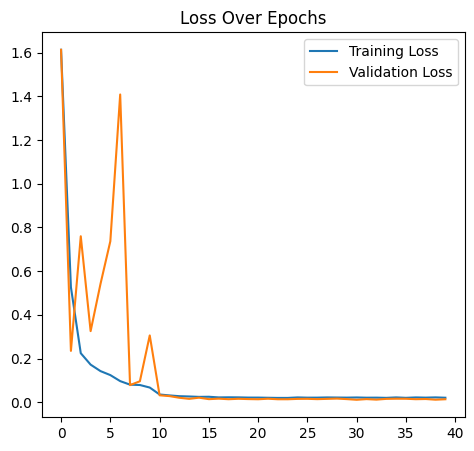

In [28]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')


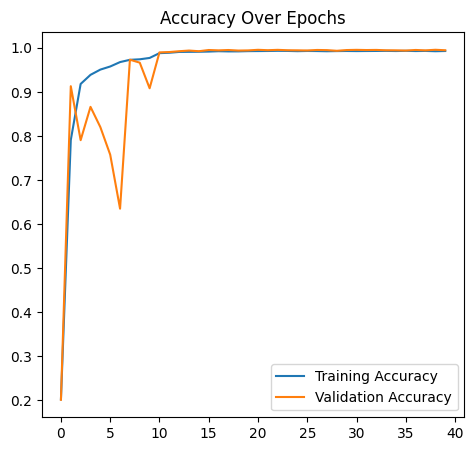

In [29]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 2)
plt.plot(history.history['custom_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_custom_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()

In [30]:
y_true = np.array(test_generator.classes)
y_pred = ensemble_model.predict(test_generator)
y_pred_prob = np.argmax(y_pred,axis=1)
rice_names = df_test["label"].unique()

352/352 [==============================] - 15s 42ms/step


In [31]:
print(rice_names)

['Karacadag' 'Basmati' 'Ipsala' 'Arborio' 'Jasmine']


In [32]:
sample_pred_prob = ensemble_model.predict(next(iter(test_generator))[0])
print("Sample prediction shape:", sample_pred_prob.shape)

1/1 [==============================] - 1s 528ms/step
Sample prediction shape: (32, 5)


In [33]:
y_true_one_hot = label_binarize(y_true, classes=np.arange(num_classes))

In [34]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

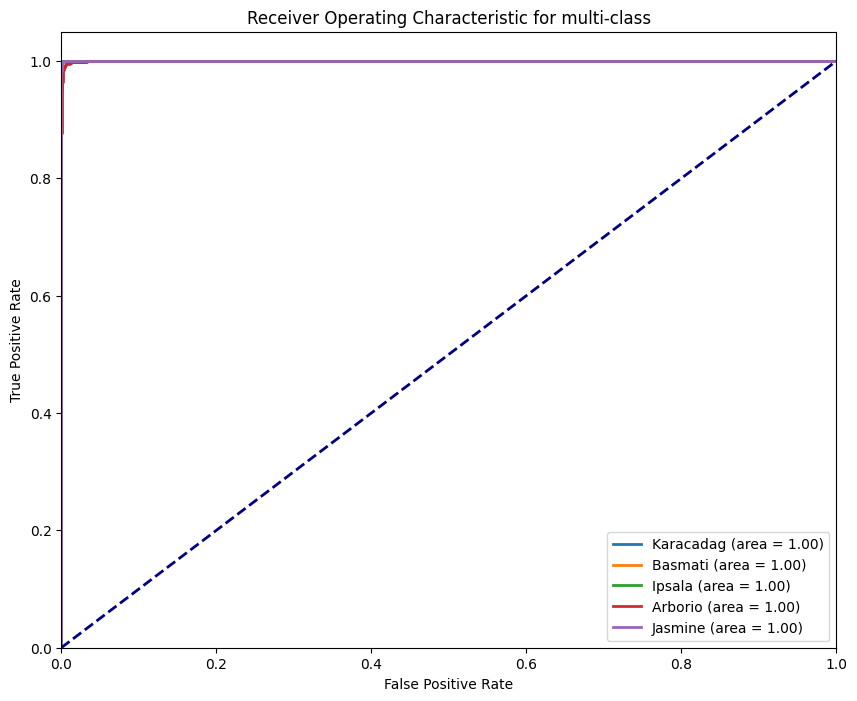

In [35]:
#ROC-AUC curve
plt.figure(figsize=(10, 8))
for i, name in enumerate(rice_names):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{name} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class')
plt.legend(loc="lower right")
plt.show()

In [36]:
#recll
recall = recall_score(y_true=test_generator.classes,y_pred=y_pred_prob,average=None)
print('recall')
print(recall)

recall
[0.9901301  0.99371352 0.9995777  0.99115436 0.99168591]


In [37]:
print("y_true shape:", y_true.shape)
print("y_pred shape:", y_pred.shape)

y_true shape: (11250,)
y_pred shape: (11250, 5)


In [38]:
cm = confusion_matrix(y_true, y_pred_prob)

In [39]:
#sensitivity
sensitivity = np.diag(cm) / np.sum(cm, axis=1)
print("Sensitivity:", sensitivity)

Sensitivity: [0.9901301  0.99371352 0.9995777  0.99115436 0.99168591]


In [40]:
#specificity
specificity = (np.sum(cm) - np.sum(cm, axis=0) - np.diag(cm) + np.diag(cm)) / (np.sum(cm) - np.sum(cm, axis=1))
print("Specificity:", specificity)

Specificity: [0.99922403 1.00121911 1.00011259 0.99777506 1.00165107]


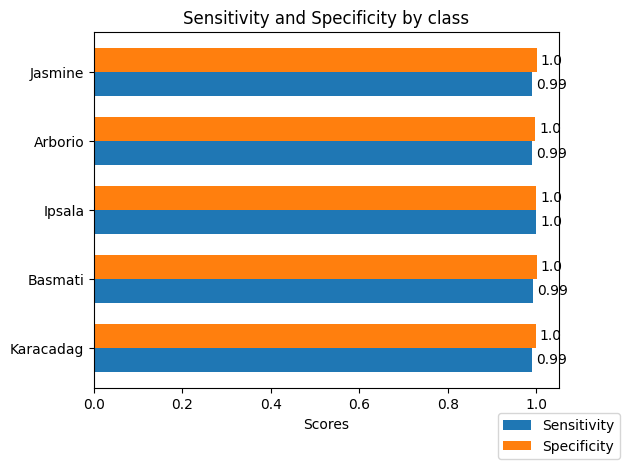

In [41]:
#sensitivity and specificity
y = np.arange(len(rice_names))  
width = 0.35 

fig, ax = plt.subplots()
rects1 = ax.barh(y - width/2, sensitivity, width, label='Sensitivity')
rects2 = ax.barh(y + width/2, specificity, width, label='Specificity')

ax.set_xlabel('Scores')
ax.set_title('Sensitivity and Specificity by class')
ax.set_yticks(y)
ax.set_yticklabels(rice_names)
ax.legend(loc='upper center', bbox_to_anchor=(1, -0.05))

def autolabel(rects):
    for rect in rects:
        width = rect.get_width()
        ax.annotate('{}'.format(round(width, 2)),
                    xy=(width, rect.get_y() + rect.get_height() / 2),
                    xytext=(3, 0),
                    textcoords="offset points",
                    ha='left', va='center')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()


In [42]:
# precision recall F1
rice_names=df_test["label"].unique()
print(classification_report(y_true, y_pred_prob,target_names = rice_names))

              precision    recall  f1-score   support

   Karacadag       0.99      0.99      0.99      2229
     Basmati       1.00      0.99      1.00      2227
      Ipsala       1.00      1.00      1.00      2368
     Arborio       0.98      0.99      0.99      2261
     Jasmine       1.00      0.99      1.00      2165

    accuracy                           0.99     11250
   macro avg       0.99      0.99      0.99     11250
weighted avg       0.99      0.99      0.99     11250



In [43]:
#confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[2207    0    0   21    1]
 [   0 2213    0   14    0]
 [   1    0 2367    0    0]
 [  16    2    0 2241    2]
 [  12    1    0    5 2147]]


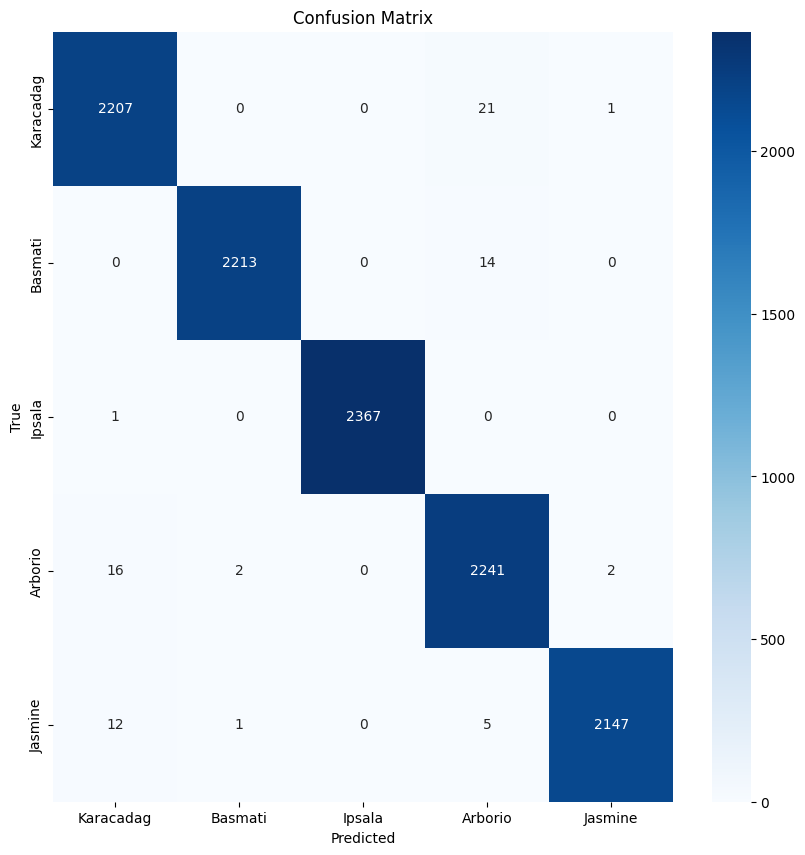

In [44]:
f,ax=plt.subplots(figsize=(10,10))
sns.heatmap(cm,annot=True,cmap='Blues', fmt='d', xticklabels=rice_names, yticklabels=rice_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

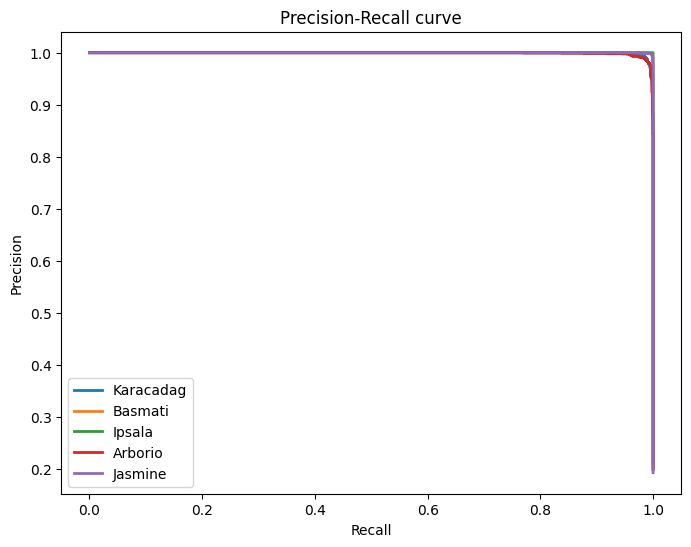

In [45]:
#Precision-Recall curve
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_true == i, y_pred[:, i])
    plt.plot(recall, precision, lw=2, label=rice_names[i])

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="best")
plt.show()

1/1 [==============================] - 0s 16ms/step


C:\Users\Edward\AppData\Local\Temp\ipykernel_19644\4187223188.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


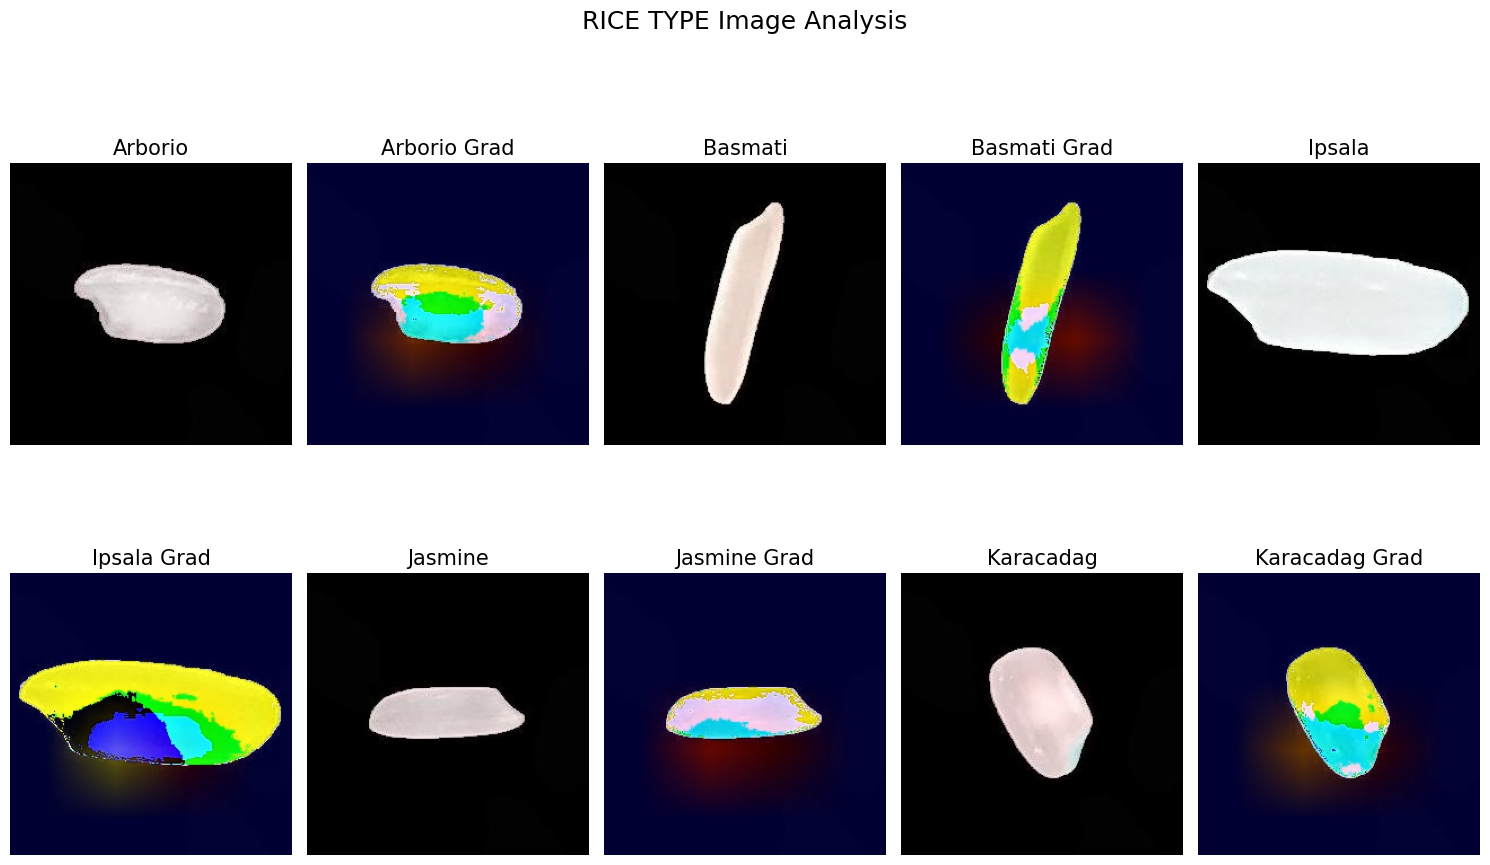

In [46]:
import matplotlib.cm as cm

list_images_sample = [
    "E:/L6C6/mv/Rice_Image_Dataset/Arborio/Arborio (1).jpg",
    "E:/L6C6/mv/Rice_Image_Dataset/Basmati/Basmati (1).jpg",
    "E:/L6C6/mv/Rice_Image_Dataset/Ipsala/Ipsala (1).jpg",
    "E:/L6C6/mv/Rice_Image_Dataset/Jasmine/Jasmine (1).jpg",
    "E:/L6C6/mv/Rice_Image_Dataset/Karacadag/Karacadag (1).jpg"
]


for layer in reversed(model_1.layers):
    if isinstance(layer, keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break

def get_img_array(img_path, size):
    img = load_img(img_path, target_size=size)
    array = img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

heatmaps = []
for img_path in list_images_sample:
    img_array = preprocess_input(get_img_array(img_path, size=(50, 50)))
    preds = model_1.predict(img_array)
    heatmap = make_gradcam_heatmap(img_array, model_1, last_conv_layer_name)
    heatmaps.append(heatmap)

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = load_img(img_path)
    img = img_to_array(img)
    heatmap = np.uint8(255 * heatmap)
    jet = plt.cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = cv2.resize(jet_heatmap, (img.shape[1], img.shape[0]))
    jet_heatmap = np.uint8(255 * jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = np.uint8(superimposed_img)
    cv2.imwrite(cam_path, superimposed_img)

for i, img_path in enumerate(list_images_sample):
    save_and_display_gradcam(img_path, heatmaps[i], f"cam_{i}.jpg")

def plot_multiple_img(img_matrix_list, title_list, ncols, main_title=""):
    fig, axes = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 10))
    fig.suptitle(main_title, fontsize=18)
    
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        row = i // ncols
        col = i % ncols
        axes[row, col].imshow(img)
        axes[row, col].set_title(title, fontsize=15)
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

images = []
titles = ["Arborio",'Arborio Grad','Basmati','Basmati Grad','Ipsala','Ipsala Grad','Jasmine','Jasmine Grad','Karacadag','Karacadag Grad']
for i, img_path in enumerate(list_images_sample):
    images.append(cv2.imread(img_path))
    images.append(cv2.imread(f"cam_{i}.jpg"))

plot_multiple_img(images, titles, ncols=5, main_title="RICE TYPE Image Analysis")


1/1 [==============================] - 0s 15ms/step


C:\Users\Edward\AppData\Local\Temp\ipykernel_19644\1804143365.py:50: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)
C:\Users\Edward\AppData\Local\Temp\ipykernel_19644\1804143365.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


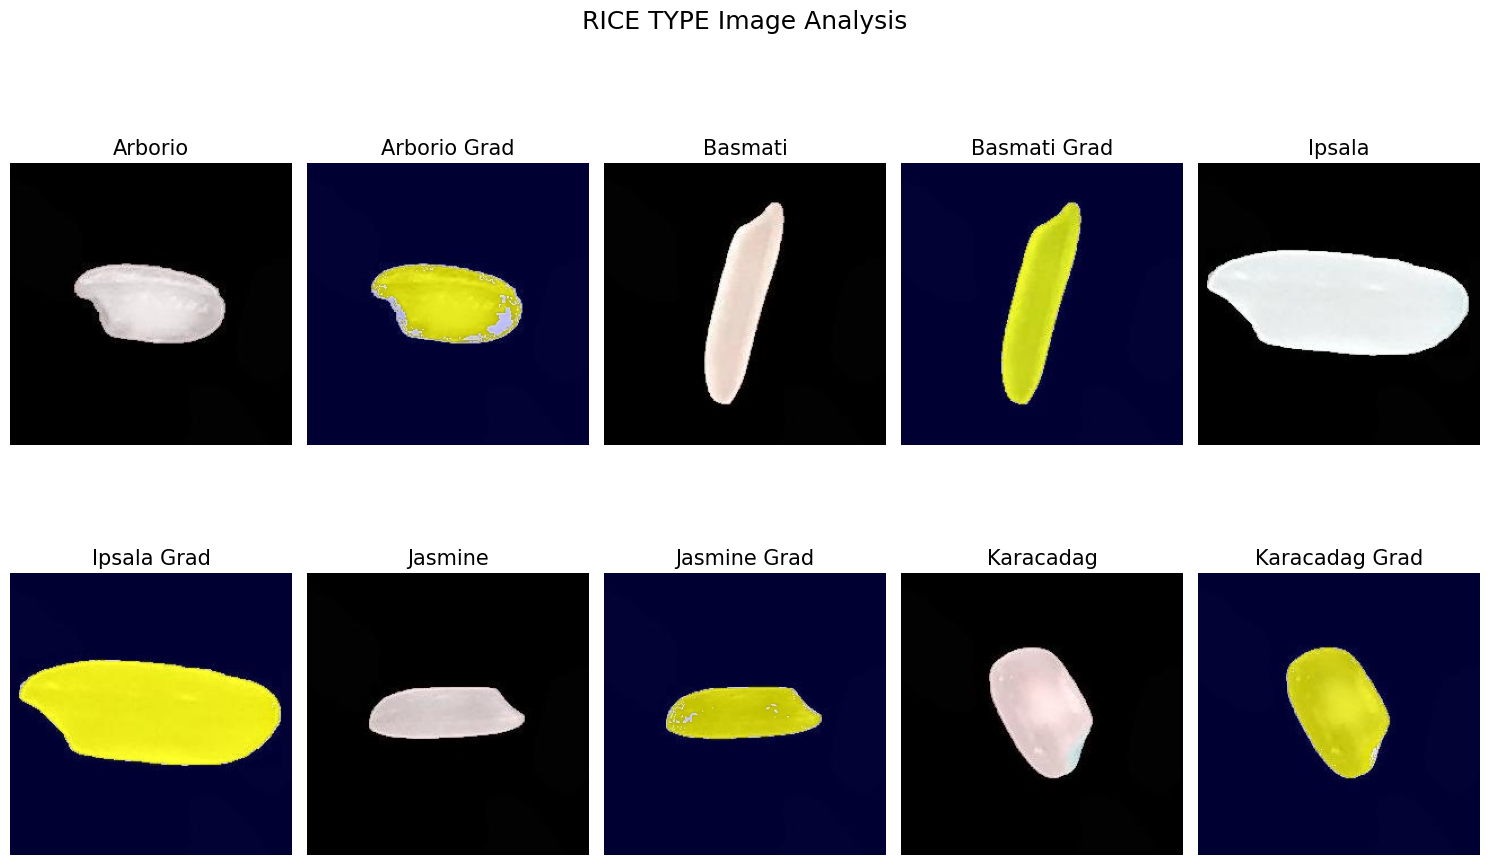

In [47]:
list_images_sample = [
    "E:/L6C6/mv/Rice_Image_Dataset/Arborio/Arborio (1).jpg",
    "E:/L6C6/mv/Rice_Image_Dataset/Basmati/Basmati (1).jpg",
    "E:/L6C6/mv/Rice_Image_Dataset/Ipsala/Ipsala (1).jpg",
    "E:/L6C6/mv/Rice_Image_Dataset/Jasmine/Jasmine (1).jpg",
    "E:/L6C6/mv/Rice_Image_Dataset/Karacadag/Karacadag (1).jpg"
]

for layer in reversed(model_2.layers):
    if isinstance(layer, keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break

def get_img_array(img_path, size):
    img = load_img(img_path, target_size=size)
    array = img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

heatmaps = []
for img_path in list_images_sample:
    img_array = preprocess_input(get_img_array(img_path, size=(50, 50)))
    preds = model_2.predict(img_array)
    heatmap = make_gradcam_heatmap(img_array, model_2, last_conv_layer_name)
    heatmaps.append(heatmap)

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = load_img(img_path)
    img = img_to_array(img)
    heatmap = np.uint8(255 * heatmap)
    jet = plt.cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = cv2.resize(jet_heatmap, (img.shape[1], img.shape[0]))
    jet_heatmap = np.uint8(255 * jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = np.uint8(superimposed_img)
    cv2.imwrite(cam_path, superimposed_img)

for i, img_path in enumerate(list_images_sample):
    save_and_display_gradcam(img_path, heatmaps[i], f"cam_{i}.jpg")

def plot_multiple_img(img_matrix_list, title_list, ncols, main_title=""):
    fig, axes = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 10))
    fig.suptitle(main_title, fontsize=18)
    
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        row = i // ncols
        col = i % ncols
        axes[row, col].imshow(img)
        axes[row, col].set_title(title, fontsize=15)
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

images = []
titles = ["Arborio",'Arborio Grad','Basmati','Basmati Grad','Ipsala','Ipsala Grad','Jasmine','Jasmine Grad','Karacadag','Karacadag Grad']
for i, img_path in enumerate(list_images_sample):
    images.append(cv2.imread(img_path))
    images.append(cv2.imread(f"cam_{i}.jpg"))

plot_multiple_img(images, titles, ncols=5, main_title="RICE TYPE Image Analysis")
